### Assignment DSC212 Zachary's Karate Club Graph . 
#### Name - Krish Kaushik 
#### Roll no - IMS24118  


#### **Project Aim**

###### This assignment seeks to find communities in Zachary’s Karate Club graph by applying recursive spectral partitioning. We demonstrate the use of graph theory (modularity and eigenvalues) to reveal network clusters

###### Show the network's division into several groups as the recursive partitioning is applied.

###### Determine and evaluate crucial metrics of node influence (degree, betweenness, closeness, and local clustering).

###### Record and visualize the evolution of these metrics after each new layer of community separation

###### This project bridges theoretical network principles and algorithmic findings, offering insights into how clustering techniques and modularity maximization expose the underlying form of real-world connections.


In [37]:
# config.py

OUT_DIR = "results"
MIN_SIZE = 3
MAX_DEPTH = 20
VERBOSE = True


In [38]:
# graph_utils.py

import networkx as nx

def load_karate_graph():
    """Load and return Zachary's Karate Club graph."""
    G = nx.karate_club_graph()
    return nx.Graph(G)  # ensure simple undirected


In [39]:
# modularity.py

import numpy as np
from scipy.sparse.linalg import eigsh
from scipy.sparse import csr_matrix
import networkx as nx

def modularity_matrix(G, nodes):
    sub = G.subgraph(nodes)
    node_list = list(sub.nodes())
    A = nx.to_numpy_array(sub, nodelist=node_list)
    k = A.sum(axis=1)
    m = A.sum() / 2.0
    if m == 0:
        B = A.copy()
    else:
        B = A - np.outer(k, k) / (2.0 * m)
    return B, node_list

def leading_eigvec(B):
    n = B.shape[0]
    if n == 0:
        return None, None
    try:
        eigvals, eigvecs = eigsh(csr_matrix(B), k=min(1, n - 1), which="LA")
        return eigvals[-1], eigvecs[:, -1]
    except Exception:
        w, v = np.linalg.eigh(B)
        return w[-1], v[:, -1]


In [40]:
# partitioning.py

import numpy as np
#from modularity import modularity_matrix, leading_eigvec

def split_by_leading_eig(G, nodes, min_size=3):
    if len(nodes) <= min_size:
        return None
    B, node_list = modularity_matrix(G, nodes)
    lam, vec = leading_eigvec(B)
    if lam is None or lam <= 1e-10:
        return None
    signs = np.sign(vec)
    signs[signs == 0] = 1e-9
    left = [node_list[i] for i in range(len(node_list)) if signs[i] > 0]
    right = [node_list[i] for i in range(len(node_list)) if signs[i] < 0]
    if len(left) < min_size or len(right) < min_size:
        return None
    return left, right, lam

def recursive_partition(G, nodes, min_size=3, max_depth=20, verbose=True):
    partition_map = {n: 0 for n in nodes}
    history = [partition_map.copy()]
    stack = [(nodes, 0, 0)]
    next_comm = 1
    splits = []

    while stack:
        nset, cid, depth = stack.pop()
        if depth >= max_depth:
            continue
        res = split_by_leading_eig(G, nset, min_size)
        if not res:
            continue
        left, right, lam = res
        rid = next_comm
        next_comm += 1
        for n in left: partition_map[n] = cid
        for n in right: partition_map[n] = rid
        splits.append((nset, left, right, lam))
        if verbose:
            print(f"Split {cid} -> {len(left)} + {len(right)}; eig={lam:.4f}")
        stack.extend([(left, cid, depth + 1), (right, rid, depth + 1)])
        history.append(partition_map.copy())
    return partition_map, history, splits


In [41]:
# metrics.py

import networkx as nx

def compute_node_metrics(G):
    return {
        "degree": nx.degree_centrality(G),
        "betweenness": nx.betweenness_centrality(G, normalized=True),
        "closeness": nx.closeness_centrality(G),
        "clustering": nx.clustering(G)
    }

def track_metrics(G, history):
    data = []
    for h in history:
        m = compute_node_metrics(G)
        m["partition"] = h.copy()
        data.append(m)
    return data


In [42]:
# visualization.py

import matplotlib.pyplot as plt
import networkx as nx
import os

def visualize_partition(G, partition, pos=None, title=None, path=None):
    if pos is None:
        pos = nx.spring_layout(G, seed=42)
    colors = [partition[n] for n in G.nodes()]
    plt.figure(figsize=(6, 5))
    nx.draw(G, pos, node_color=colors, cmap=plt.cm.tab10, with_labels=True)
    plt.title(title or "Partition")
    plt.axis("off")
    if path:
        plt.savefig(path, bbox_inches="tight")
    plt.show()
    return pos

def plot_metric_evolution(metrics, metric="degree", path=None):
    its = range(len(metrics))
    final = metrics[-1][metric]
    top_nodes = sorted(final, key=final.get, reverse=True)[:4]
    plt.figure(figsize=(8, 4))
    for n in top_nodes:
        vals = [m[metric].get(n, 0) for m in metrics]
        plt.plot(its, vals, marker='o', label=f"node {n}")
    plt.xlabel("Iteration")
    plt.ylabel(metric)
    plt.legend()
    plt.title(f"{metric} Evolution")
    if path:
        plt.savefig(path, bbox_inches="tight")
    plt.show()


Loaded Karate Club graph: n=34, m=78
Split 0 -> 18 + 16; eig=17.1087
Split 1 -> 7 + 9; eig=10.3122
Split 1 -> 4 + 3; eig=3.4412
Split 0 -> 6 + 12; eig=7.8764
Split 0 -> 3 + 3; eig=3.5619


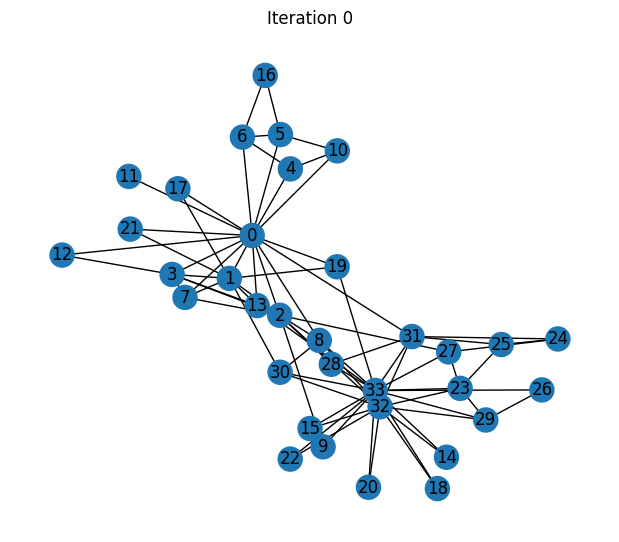

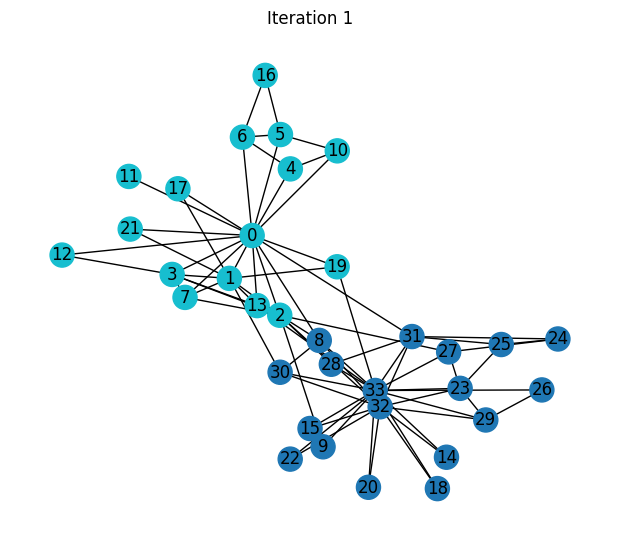

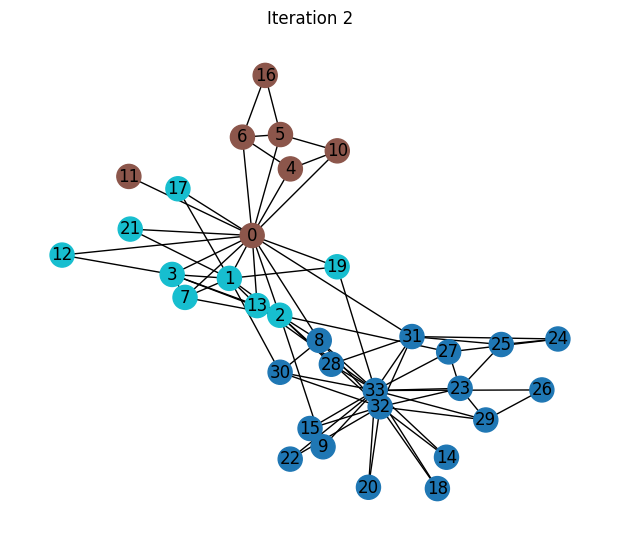

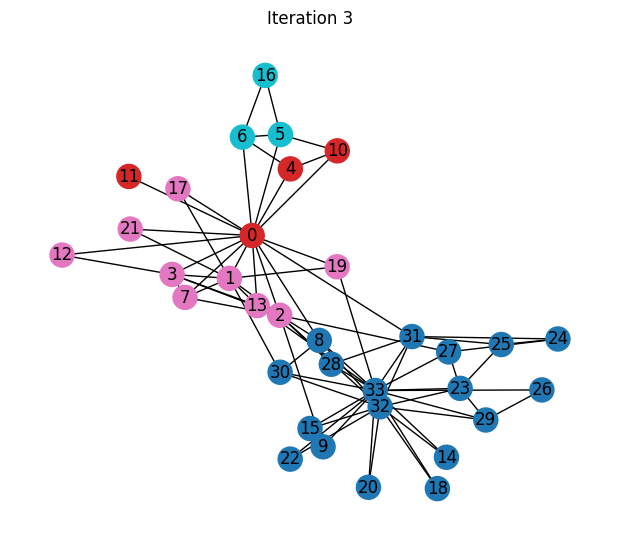

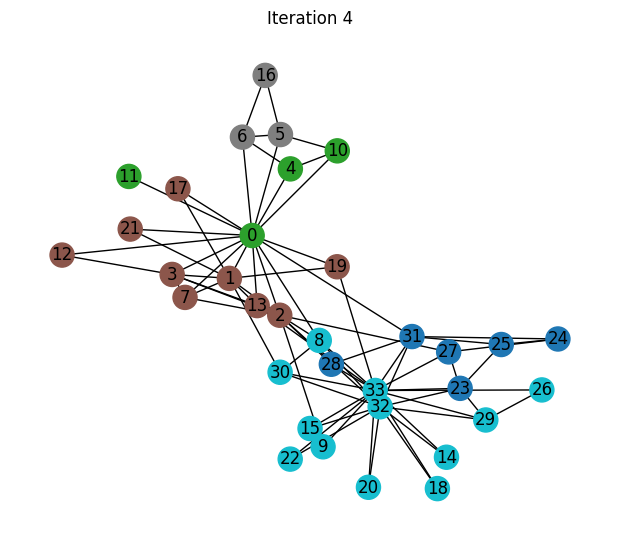

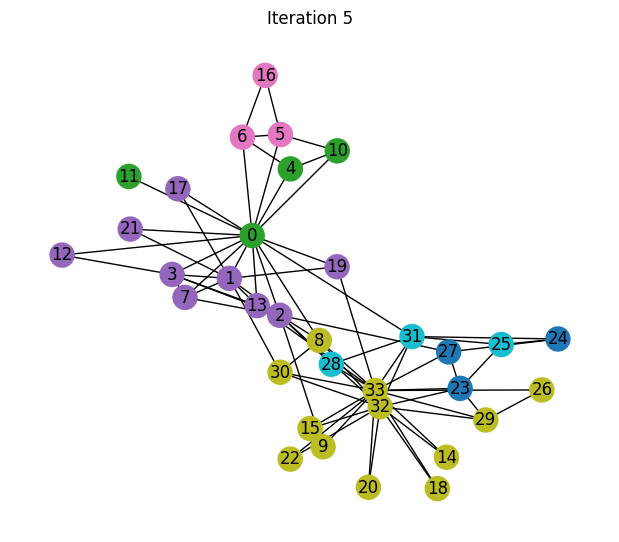

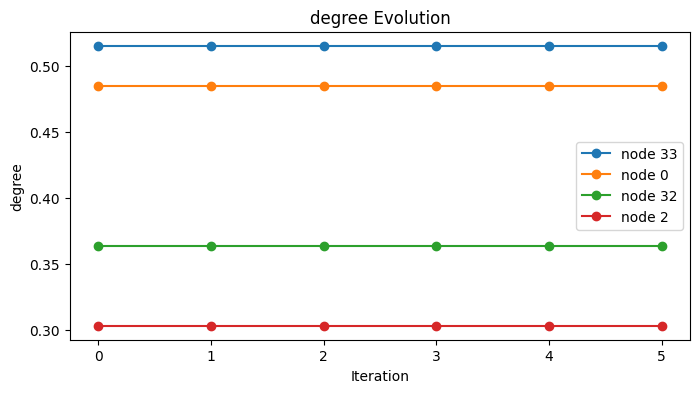

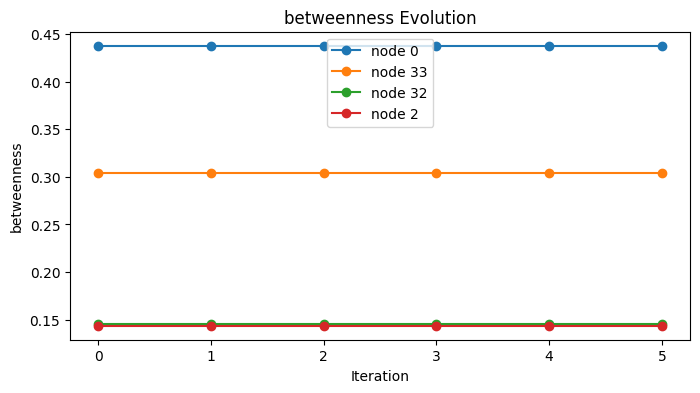

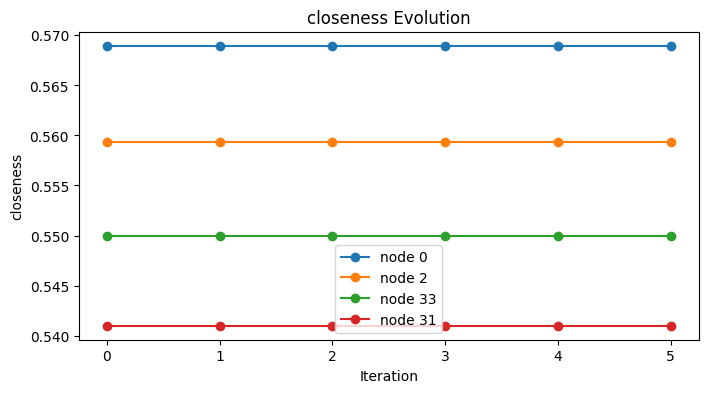

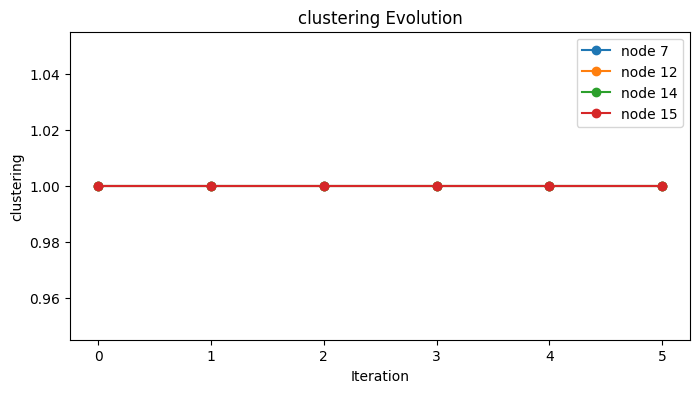


Discussion:
1.Pinpoint the nodes that maintain their high importance and structural role despite the network partitions.
2.Note how the Betweenness Centrality of nodes situated on the former community borders changes dramatically as the splits occur.
3.Explain the correlation between the Clustering Coefficient values and the tightness or density within the newly formed communities.


In [43]:
# main.py

import os
'''
from config import OUT_DIR, MIN_SIZE, MAX_DEPTH, VERBOSE
from graph_utils import load_karate_graph
from partitioning import recursive_partition
from metrics import track_metrics
from visualization import visualize_partition, plot_metric_evolution
'''
def main():
    os.makedirs(OUT_DIR, exist_ok=True)
    G = load_karate_graph()
    print(f"Loaded Karate Club graph: n={G.number_of_nodes()}, m={G.number_of_edges()}")

    partition, history, splits = recursive_partition(G, list(G.nodes()), MIN_SIZE, MAX_DEPTH, VERBOSE)

    pos = None
    for i, p in enumerate(history):
        pos = visualize_partition(G, p, pos, f"Iteration {i}", os.path.join(OUT_DIR, f"iter_{i}.png"))

    metrics = track_metrics(G, history)
    for m in ["degree", "betweenness", "closeness", "clustering"]:
        plot_metric_evolution(metrics, metric=m, path=os.path.join(OUT_DIR, f"{m}_evolution.png"))

    print("\nDiscussion:\n1.Pinpoint the nodes that maintain their high importance and structural role despite the network partitions.\n2.Note how the Betweenness Centrality of nodes situated on the former community borders changes dramatically as the splits occur.\n3.Explain the correlation between the Clustering Coefficient values and the tightness or density within the newly formed communities.")

if __name__ == "__main__":
    main()
